# Remove Boxes Demo

In [1]:
%load_ext autoreload
%autoreload 2

This notebook shows how to remove boxes from a form as these boxes can cause OCR misreads if the text overlaps with the boundaries of the box

#### Install BoxDetect package to automagically detect boxes with handwritten characters

In [ ]:
import sys

! {sys.executable} -m pip install git+https://github.com/karolzak/boxdetect moment

In [2]:
import sys
import os
sys.path.append(".")
import matplotlib.pyplot as plt
from requests import get, post, delete
import time

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline 

__root_common__ = 'common.py'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__root_common__), '..')))

__train_file__ = 'autolabel_training.py'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__train_file__), '..')))

import numpy as np
from boxdetect import config
from common.common import compute_partial_ratio, compute_ratio, get_text_from_ocr, score_and_rank, \
apply_erosion, apply_dilatation, get_projection, load_image, find_runs, analyze_runs
from Training.Auto_Labelling.basic_implementation.autolabel_training import call_ocr

best_score = {}

config.thickness = 3
DATA_PATH = '../Data/'
file_name = 'form_example1.png'


# Now we autodetect boxes on the form

In [3]:
from boxdetect import config

# important to adjust these values to match the size of boxes on your image
config.min_w, config.max_w = (35,50)
config.min_h, config.max_h = (28,40)

# the more scaling factors the more accurate the results but also it takes more time to processing
# too small scaling factor may cause false positives
# too big scaling factor will take a lot of processing time
config.scaling_factors = [0.7]

# w/h ratio range for boxes/rectangles filtering
config.wh_ratio_range = (0.5, 1.5)

# num of iterations when running dilation tranformation (to engance the image)
config.dilation_iterations = 0

In [4]:
from boxdetect.pipelines import get_boxes

rects, grouping_rects, img, output_image = get_boxes(
    os.path.join(DATA_PATH, file_name), config=config, plot=False)

Processing file:  ../Data/form_example1.png


## Each rectangle is a big region of box rectangles
 (x, y, w, h)

In [5]:
grouping_rects

[(263, 361, 1197, 38),
 (262, 427, 1198, 37),
 (270, 488, 1190, 36),
 (311, 550, 420, 34),
 (362, 629, 680, 35),
 (369, 820, 1098, 37),
 (369, 860, 1098, 36),
 (369, 901, 432, 34),
 (369, 960, 432, 34),
 (958, 959, 398, 33),
 (369, 1024, 432, 35),
 (958, 1023, 400, 35),
 (244, 1124, 386, 33),
 (753, 1123, 155, 33),
 (1024, 1121, 400, 34),
 (242, 1189, 345, 34),
 (863, 1187, 421, 34),
 (242, 1256, 1193, 35),
 (240, 1324, 435, 33)]

## Let's see what has been detected 

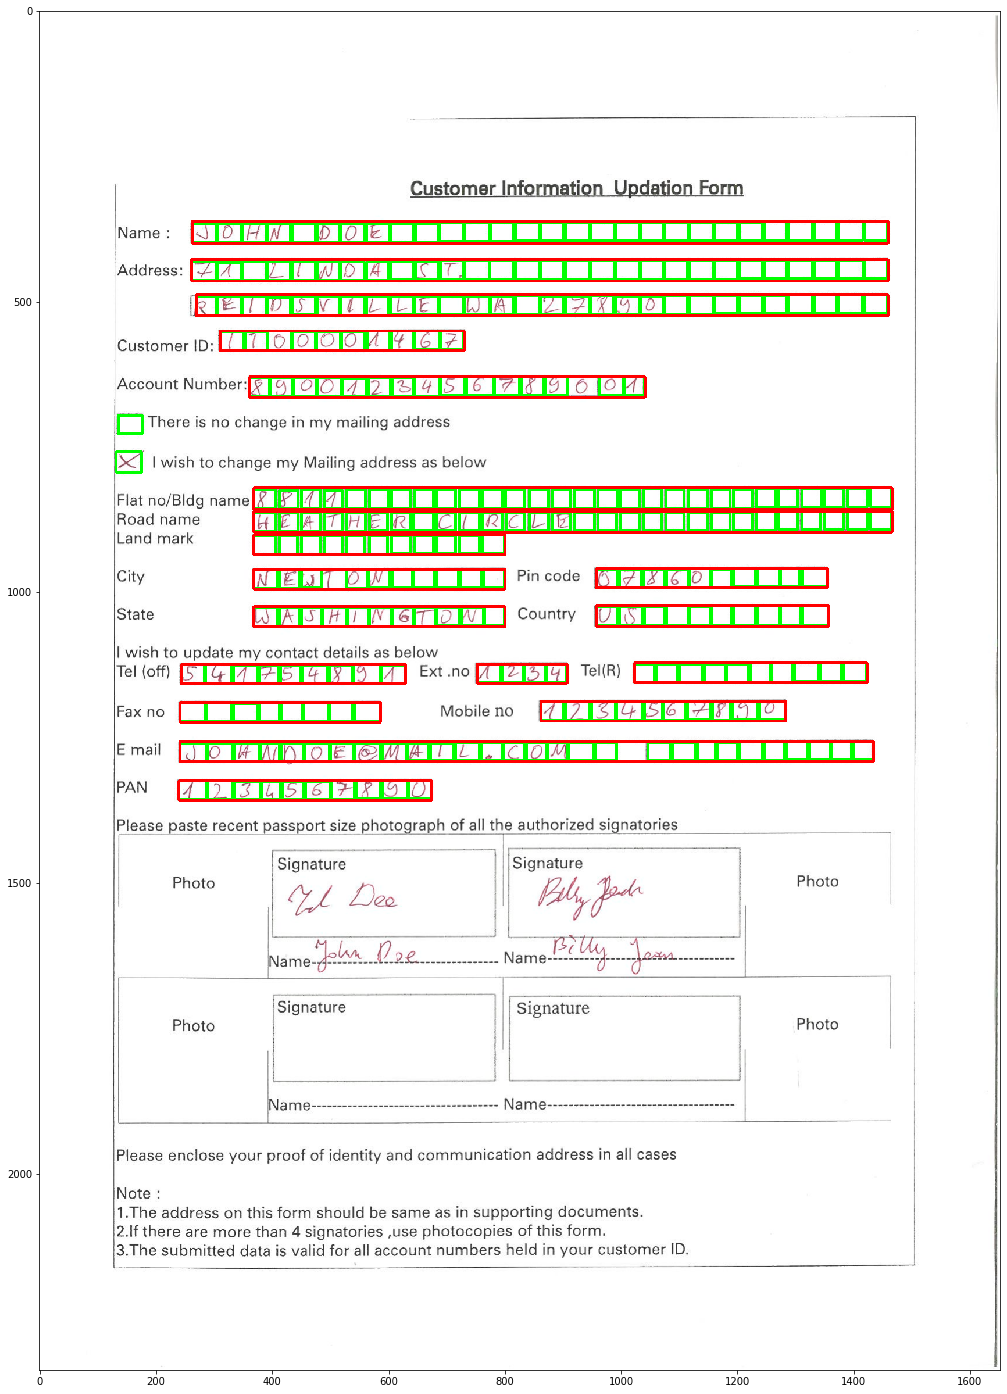

In [6]:
plt.figure(figsize=(25,25))
plt.imshow(output_image)

# Here you can interactively extract each section that the detect boxes has identified - use this to tune the sensitivity of the region extraction

In [7]:
from ipywidgets import interact

@interact(i=(0, len(grouping_rects)-1))
def extract_region(i):
    
    window1 = 1   # Tweak these sensitivity values
    window2 = 0.01  # Tweak these sensitivity values
    
    y1 = int(grouping_rects[i][1] + (window1 * grouping_rects[i][3]))   
    y2 = int(grouping_rects[i][1] - (window2 * grouping_rects[i][3]))
    x1 = int(grouping_rects[i][0] + (window1 * grouping_rects[i][2]))
    x2 = int(grouping_rects[i][0] - (window2 * grouping_rects[i][2]))
    roi = output_image[y2:y1, x2:x1]
    plt.imshow(roi)
    


interactive(children=(IntSlider(value=9, description='i', max=18), Output()), _dom_classes=('widget-interact',…

# Let's drilldown on one of the fields 

Experiment with the values for window1 and window2 below to fit the region snugly with the detected boxes

In [8]:
import imutils

window1 = 1   # Tweak these sensitivity values
window2 = 0.01  # Tweak these sensitivity values

# Let's take one field as an example
i = 17
    
y1 = int(grouping_rects[i][1] + (window1 * grouping_rects[i][3]))   
y2 = int(grouping_rects[i][1] - (window2 * grouping_rects[i][3]))
x1 = int(grouping_rects[i][0] + (window1 * grouping_rects[i][2]))
x2 = int(grouping_rects[i][0] - (window2 * grouping_rects[i][2]))
roi = output_image[y2:y1, x2:x1]

# Let's save the image
image = cv2.imread(os.path.join(DATA_PATH, file_name))
roi = image[y2:y1, x2:x1]
active_file = 'field.jpg'
# required minimum size for OCR is 50x50 pixels so check and rescale if needed
if abs(y1-y2) < 50:
    roi = imutils.resize(
        roi, height=50)
saved = cv2.imwrite(os.path.join(DATA_PATH, active_file), roi)

assert saved == True
print(f"{DATA_PATH + active_file} saved")

../Data/field.jpg saved


## Set up our environment variables

In [9]:
# We will set up some of the environment variables here and others later in the notebook to keep things clear
# Set the values here marked with SET THIS HERE
class Config:
    """
    Read from .env file
    """
    REGION = 'eastus'  # The region Form Recognizer and OCR are deployed
    SUBSCRIPTION_KEY = ''  # CogSvc key frautolabel | Keys and Endpoint

    

# Let's call OCR and score against the Ground Truth - Enter the GT here

In [10]:
GT = 'JOHNDOE@MAIL.COM'    # This is the ground truth value for the field
result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score, top_score = score_and_rank(active_file, GT, result, best_score)

Analyzing file field.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze

File field.jpg status: succeeded
field.jpg Score 88.5
GT: JOHNDOE@MAIL.COM OCR: JOANDOE@MAILCOM

-----Best performing images----------
 0: field.jpg 88.5


## Let's get our baseline score

In [11]:
baseline_score = top_score[0][1]
print(f"Baseline score {baseline_score}")

Baseline score 88.5


# Let's find the best performing image transformation

In [12]:
image = cv2.imread(os.path.join(DATA_PATH, active_file))
gray = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# Remove vertical
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)
    
# Repair image
repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,6))
result = 255 - cv2.morphologyEx(255 - image, cv2.MORPH_CLOSE, repair_kernel, iterations=1)

saved = cv2.imwrite(os.path.join(DATA_PATH, 'thresh.jpg'), thresh)
assert saved == True
print(f"{DATA_PATH + 'thresh.jpg'} saved")
saved = cv2.imwrite(os.path.join(DATA_PATH, 'detected.jpg'), detected_lines)
assert saved == True
print(f"{DATA_PATH + 'detected.jpg'} saved")
saved = cv2.imwrite(os.path.join(DATA_PATH, 'roi.jpg'), roi)
assert saved == True
print(f"{DATA_PATH + 'roi.jpg'} saved")


active_file = 'roi.jpg'
result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score, top_score = score_and_rank(active_file, GT, result, best_score)

inverted_active_file = 'thresh.jpg'
result = call_ocr(DATA_PATH, inverted_active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
best_score, top_score = score_and_rank(active_file, GT, result, best_score)

for i in range(2):
    i+=1

    active_file = apply_dilatation(DATA_PATH, active_file, i)
    result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
    best_score, top_score = score_and_rank(active_file, GT, result, best_score)

    active_file = apply_erosion(DATA_PATH, active_file, i)
    result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
    best_score, top_score = score_and_rank(active_file, GT, result, best_score)

    active_file = apply_erosion(DATA_PATH, inverted_active_file, i)
    result = call_ocr(DATA_PATH, active_file, 'en', Config.REGION, Config.SUBSCRIPTION_KEY, 'image/jpeg')
    best_score, top_score = score_and_rank(inverted_active_file, GT, result, best_score)



../Data/thresh.jpg saved
../Data/detected.jpg saved
../Data/roi.jpg saved
Analyzing file roi.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze

File roi.jpg status: succeeded
roi.jpg Score 88.5
GT: JOHNDOE@MAIL.COM OCR: JOANDOE@MAILCOM

-----Best performing images----------
 0: field.jpg 88.5
 1: roi.jpg 88.5
Analyzing file thresh.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze

File thresh.jpg status: succeeded
roi.jpg Score 82.0
GT: JOHNDOE@MAIL.COM OCR: JOAMOE@MAIL.COM

-----Best performing images----------
 0: field.jpg 88.5
 1: roi.jpg 82.0
Analyzing file roi1_dilatation.jpg...
https://eastus.api.cognitive.microsoft.com/formrecognizer/v2.0-preview/layout/analyze

File roi1_dilatation.jpg status: succeeded
roi1_dilatation.jpg Score 83.0
GT: JOHNDOE@MAIL.COM OCR: JOANDOE@MAICOM

-----Best performing images----------
 0: field.jpg 88.5
 1: roi1_dilatation.jpg 83.0
 2: roi.jpg 82.0
Analyzing file r

In [13]:
print(f"Baseline score {baseline_score}")
print(f"Best performing image {top_score[0][0]} {top_score[0][1]}")

Baseline score 88.5
Best performing image roi1_dilatation1_eroded.jpg 95.0
